In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import xarray as xr
import os
os.environ['R_HOME'] = '/home/luhung3080/miniconda3/envs/chou/lib/R'
from rpy2.robjects import r, numpy2ri
numpy2ri.activate()
from rpy2.robjects.packages import importr
sinkr = importr('sinkr')
import Nio
print ("pynio ver . ",Nio.__version__)

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch ver .  1.11.0+cu113
Is CUDA available? True
pynio ver .  1.5.5


# Data

In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')
data

,SITE_ID,date,FCST_TIME,TAU,pm25_cal,pm25_obs
0,EPA001,2020-02-24 08:00:00,2020-02-24 09:00:00,1,4.9510,10.0
1,EPA001,2020-02-24 08:00:00,2020-02-24 10:00:00,2,4.4674,13.0
2,EPA001,2020-02-24 08:00:00,2020-02-24 11:00:00,3,4.6159,11.0
3,EPA001,2020-02-24 08:00:00,2020-02-24 12:00:00,4,3.9937,11.0
4,EPA001,2020-02-24 08:00:00,2020-02-24 13:00:00,5,3.9602,9.0
...,...,...,...,...,...,...
3092755,EPA080,2021-10-30 08:00:00,2021-11-02 04:00:00,68,3.6190,4.0
3092756,EPA080,2021-10-30 08:00:00,2021-11-02 05:00:00,69,3.7908,7.0
3092757,EPA080,2021-10-30 08:00:00,2021-11-02 06:00:00,70,4.0454,7.0
3092758,EPA080,2021-10-30 08:00:00,2021-11-02 07:00:00,71,3.9015,4.0


In [3]:
###
#cal_PMf  
###
u=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    u[i]=a.T

###
#obs_PMf
###
v=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_obs'][5112*i:5112*i+5112])
    v[i]=a.T

print(np.shape(u))
print(np.shape(v))

(605, 5112)
(605, 5112)


In [4]:
XRestruct_Fun=u
YRestruct_Fun=v
print(np.shape(XRestruct_Fun))
print(np.shape(YRestruct_Fun))

(605, 5112)
(605, 5112)


In [5]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([544,5112])
Yhat_train = np.zeros([544,5112])
Xhat_val = np.zeros([61,5112])
Yhat_val = np.zeros([61,5112])
Xhat_test = np.zeros([61,5112])
Yhat_test = np.zeros([61,5112])

for i in range (0,544):
    for j in range (0,5112):    
        Xhat_train[i][j] = Xhat[i][j]
        Yhat_train[i][j] = Yhat[i][j]
        
for i in range (544,605):
    for j in range (0,5112):
        Xhat_val[i-544][j] = Xhat[i][j]
        Yhat_val[i-544][j] = Yhat[i][j]     
        
for i in range (544,605):
    for j in range (0,5112):
        Xhat_test[i-544][j] = Xhat[i][j]
        Yhat_test[i-544][j] = Yhat[i][j]
print('Xhat_train')
print(np.shape(Xhat_train))
print('Yhat_train')
print(np.shape(Yhat_train))
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))
print('Xhat_test')
print(np.shape(Xhat_test))
print('Yhat_test')
print(np.shape(Yhat_test))

Xhat_train
(544, 5112)
Yhat_train
(544, 5112)
Xhat_val
(61, 5112)
Yhat_val
(61, 5112)
Xhat_test
(61, 5112)
Yhat_test
(61, 5112)


# Pytorch lightning Model

In [6]:
x_train = torch.from_numpy(Xhat_train).float()
y_train = torch.from_numpy(Yhat_train).float()
x_val = torch.from_numpy(Xhat_val).float()
y_val = torch.from_numpy(Yhat_val).float()
x_test = torch.from_numpy(Xhat_test).float()
y_test = torch.from_numpy(Yhat_test).float()

In [7]:
class PytorchLightningModel(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(5112 , 5112)

    def forward(self, x): 
        ouput = self.layer1(x)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): # 此方法會在初始化後優先執行。 所以可以在此方法中先將會用到的資料都讀取進來.
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)
        # logging.info("===== Data is ready... =====")

    def train_dataloader(self):
        # return Data.DataLoader(dataset=self.train_set, batch_size= self.batch_size, shuffle=True)
        return Data.DataLoader(dataset=self.train_set , batch_size=544 , shuffle=True)

    def test_dataloader(self):
        # return Data.DataLoader(dataset=self.test_set, batch_size= self.batch_size, shuffle=True)
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        #return Data.DataLoader(dataset=self.val_set, batch_size= self.batch_size, shuffle=True)
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("train_loss_MAE", loss)
        return {'loss' : loss , 'log' : logs }

    def test_step(self, batch, batch_idx): #定義 Test 階段
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("test_loss_MAE", loss)
        return {'loss' : loss ,'log' : logs}

    # def test_eposh_end(self, outputs):
    #     avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
    #     logs = {'test_loss': avg_loss}      
    #     #return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }
    #     return {'avg_test_loss': avg_loss, 'log': logs}

    def validation_step(self, batch, batch_idx): # 定義Validation如何進行，以這邊為例就再加上了計算Acc.
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("val_loss_MAE", loss)
        return {'loss' : loss ,  'log' : logs}
    
    
    # def validation_epoch_end(self, outputs): # 在Validation的一個Epoch結束後，計算平均的Loss.
    #     avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    #     logs = {'val_loss': avg_loss}
    #     return {'avg_val_loss': avg_loss, 'log' : logs, 'progress_bar': logs}

In [11]:
logger1 = TensorBoardLogger("jupyterNB_logs", name="mymodel_72hr")
logger2 = CSVLogger("jupyterNB_logs", name="mymodel_72hr_csv")
model = PytorchLightningModel() 
trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger2)
trainer.fit(model)
trainer.test(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: jupyterNB_logs/mymodel_72hr_csv
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | layer1 | Linear | 26.1 M
----------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.551   Total estimated model params size (MB)


Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 53.06it/s, loss=16.2, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████        | 1/2 [00:00<00:00,  1.89it/s, loss=13.9, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:01<00:01,  1.06s/it, loss=12.3, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:01<00:01,  1.61s/it, loss=11.3, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:02<00:02,  2.18s/it, loss=10.7, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████        | 1/2 [00:02<00:02,  2.74s/it, loss=10.4, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:03<00:03,  3.27s/it, loss=10.2, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████        | 1/2 [00:04<00:04,  4.05s/it, loss=9.99, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:04<00:04,  4.57s/it, loss=9.81, v_num=0]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:30<00:30, 30.33s/it, loss=5.69, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████▌       | 1/2 [00:30<00:30, 30.85s/it, loss=5.68, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:31<00:31, 31.37s/it, loss=5.66, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:31<00:31, 31.89s/it, loss=5.64, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████▌       | 1/2 [00:32<00:32, 32.42s/it, loss=5.62, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:32<00:32, 32.94s/it, loss=5.61, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:33<00:33, 33.46s/it, loss=5.59, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:33<00:33, 33.98s/it, loss=5.57, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:34<00:34, 34.50s/it, loss=5.56, v_num=0]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [01:00<01:00, 60.08s/it, loss=5.02, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [01:00<01:00, 60.61s/it, loss=5.01, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|████████▌        | 1/2 [01:01<01:01, 61.14s/it, loss=5, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [01:01<01:01, 61.67s/it, loss=4.99, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [01:02<01:02, 62.20s/it, loss=4.99, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [01:02<01:02, 62.72s/it, loss=4.98, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [01:03<01:03, 63.25s/it, loss=4.97, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [01:03<01:03, 63.78s/it, loss=4.96, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [01:04<01:04, 64.31s/it, loss=4.95, v_num=0]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [01:30<01:30, 90.88s/it, loss=4.61, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████▌       | 1/2 [01:31<01:31, 91.42s/it, loss=4.6, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [01:31<01:31, 91.96s/it, loss=4.59, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [01:32<01:32, 92.49s/it, loss=4.59, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [01:33<01:33, 93.02s/it, loss=4.58, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [01:33<01:33, 93.54s/it, loss=4.57, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [01:34<01:34, 94.08s/it, loss=4.57, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [01:34<01:34, 94.60s/it, loss=4.56, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [01:35<01:35, 95.14s/it, loss=4.56, v_num=0]
Validation: 0it [00:00,

Epoch 228:  50%|██████▌      | 1/2 [02:01<02:01, 121.30s/it, loss=4.29, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|██████▌      | 1/2 [02:01<02:01, 121.84s/it, loss=4.28, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|██████▌      | 1/2 [02:02<02:02, 122.37s/it, loss=4.28, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|██████▌      | 1/2 [02:02<02:02, 122.90s/it, loss=4.27, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████▌      | 1/2 [02:03<02:03, 123.43s/it, loss=4.27, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████▌      | 1/2 [02:03<02:03, 123.96s/it, loss=4.26, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|██████▌      | 1/2 [02:04<02:04, 124.49s/it, loss=4.26, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|██████▌      | 1/2 [02:05<02:05, 125.02s/it, loss=4.25, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████▌      | 1/2 [02:05<02:05, 125.57s/it, loss=4.25, v_num=0]
Validation: 0it [00:00,

Epoch 285:  50%|██████▌      | 1/2 [02:31<02:31, 151.93s/it, loss=4.04, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████▌      | 1/2 [02:32<02:32, 152.46s/it, loss=4.03, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████▌      | 1/2 [02:33<02:33, 153.00s/it, loss=4.03, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|██████▌      | 1/2 [02:33<02:33, 153.53s/it, loss=4.02, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|██████▌      | 1/2 [02:34<02:34, 154.08s/it, loss=4.02, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████▌      | 1/2 [02:34<02:34, 154.61s/it, loss=4.02, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|██████▌      | 1/2 [02:35<02:35, 155.15s/it, loss=4.01, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|██████▌      | 1/2 [02:35<02:35, 155.69s/it, loss=4.01, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|██████▌      | 1/2 [02:36<02:36, 156.23s/it, loss=4.01, v_num=0]
Validation: 0it [00:00,

Epoch 342:  50%|██████▌      | 1/2 [03:02<03:02, 182.91s/it, loss=3.83, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|██████▌      | 1/2 [03:03<03:03, 183.46s/it, loss=3.83, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|██████▌      | 1/2 [03:03<03:03, 183.99s/it, loss=3.82, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|██████▌      | 1/2 [03:04<03:04, 184.53s/it, loss=3.82, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|██████▌      | 1/2 [03:05<03:05, 185.06s/it, loss=3.82, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|██████▌      | 1/2 [03:05<03:05, 185.60s/it, loss=3.81, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████▌      | 1/2 [03:06<03:06, 186.15s/it, loss=3.81, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|██████▌      | 1/2 [03:06<03:06, 186.69s/it, loss=3.81, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████▌      | 1/2 [03:07<03:07, 187.23s/it, loss=3.81, v_num=0]
Validation: 0it [00:00,

Epoch 399:  50%|██████▌      | 1/2 [03:34<03:34, 214.33s/it, loss=3.66, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|██████▌      | 1/2 [03:34<03:34, 214.87s/it, loss=3.66, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|██████▌      | 1/2 [03:35<03:35, 215.43s/it, loss=3.65, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|██████▌      | 1/2 [03:35<03:35, 215.99s/it, loss=3.65, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|██████▌      | 1/2 [03:36<03:36, 216.55s/it, loss=3.65, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|██████▌      | 1/2 [03:37<03:37, 217.11s/it, loss=3.65, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|██████▌      | 1/2 [03:37<03:37, 217.66s/it, loss=3.64, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|██████▌      | 1/2 [03:38<03:38, 218.24s/it, loss=3.64, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|██████▌      | 1/2 [03:38<03:38, 218.79s/it, loss=3.64, v_num=0]
Validation: 0it [00:00,

Epoch 456:  50%|██████▌      | 1/2 [04:05<04:05, 245.54s/it, loss=3.52, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|██████▌      | 1/2 [04:06<04:06, 246.08s/it, loss=3.51, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|██████▌      | 1/2 [04:06<04:06, 246.62s/it, loss=3.51, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|██████▌      | 1/2 [04:07<04:07, 247.17s/it, loss=3.51, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|██████▌      | 1/2 [04:07<04:07, 247.70s/it, loss=3.51, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|██████▌      | 1/2 [04:08<04:08, 248.24s/it, loss=3.51, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [04:08<04:08, 248.77s/it, loss=3.5, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [04:09<04:09, 249.30s/it, loss=3.5, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [04:09<04:09, 249.84s/it, loss=3.5, v_num=0]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 176.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          6.153849124908447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_MAE': 6.153849124908447}]

In [10]:
model_test = PytorchLightningModel.load_from_checkpoint('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/mymodel_72hr/version_0/checkpoints/epoch=499-step=500.ckpt')
trainer = pl.Trainer()  
trainer.test(model_test)

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1826: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
Missing logger folder: /home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/lightning_logs


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 47.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          6.143406867980957
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_MAE': 6.143406867980957}]

In [18]:
df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/mymodel_72hr_csv/version_0/metrics.csv")
s=np.array(df['val_loss_MAE'].fillna(np.nanmean(df['val_loss_MAE'])))
#print(s)
score=np.min(s)
print(df[df['val_loss_MAE'] == score].index)
print(score)

Int64Index([225], dtype='int64')
6.067444324493408


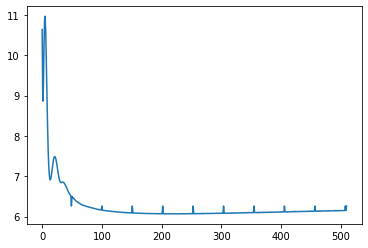

In [19]:
plt.plot(s)